In [2]:
%matplotlib inline

Model Zoo: https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md

## DeepLab Model

In [2]:
!git clone https://github.com/tensorflow/models
# From tensorflow/models/research/
!cd models/research/
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

Cloning into 'models'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 23133 (delta 21), reused 20 (delta 10), pack-reused 23094
Receiving objects: 100% (23133/23133), 562.90 MiB | 930.00 KiB/s, done.
Resolving deltas: 100% (13510/13510), done.
Checking out files: 100% (2883/2883), done.


In [3]:
# Following Code Taken From:
# https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb#scrollTo=kAbdmRmvq0Je

import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map



#######
# changed for cityscape labels
#LABEL_NAMES = np.asarray([trainId2label[i].name for i in np.arange(19)])
LABEL_NAMES = np.asarray(['road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
       'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
       'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
       'bicycle'])
#######

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
#FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

# Changed to explicitly pick just a chosen model
_TARBALL_NAME = 'deeplab_model.tar.gz'
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
#deeplab_cityscapes_xception71_trainfine_2018_09_08
#mobilenetv2_coco_cityscapes_trainfine
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
                   download_path)

print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


img_folder = '/home/project/data/Cityscapes/leftImg8bit/val/frankfurt'
img_names = os.listdir(img_folder)
img = skimage.io.imread(img_folder + '/' + random.choice(img_names))
skimage.io.imshow(img)

SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'https://i1.wp.com/www.totaltaipei.com/wp-content/uploads/2017/04/fake-accident.jpg?fit=600%2C303'

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

In [8]:
# tensorboard output
graph = MODEL.graph
writer = tf.summary.FileWriter(logdir='/home/project/models', graph=graph)
writer.flush()

In [5]:
# Following Code Taken From and adapted:
# https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb#scrollTo=kAbdmRmvq0Je


IMAGE_URL = 'https://i1.wp.com/www.totaltaipei.com/wp-content/uploads/2017/04/fake-accident.jpg?fit=600%2C303'

url = IMAGE_URL
f = urllib.request.urlopen(url)
jpeg_str = f.read()
original_im = Image.open(BytesIO(jpeg_str))

image = original_im

width, height = image.size
resize_ratio = 1.0 * MODEL.INPUT_SIZE / max(width, height)
target_size = (int(resize_ratio * width), int(resize_ratio * height))
resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)

logits = MODEL.sess.run(
    'ResizeBilinear_3:0',
    #'logits/semantic/BiasAdd:0',
    feed_dict={MODEL.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})

In [6]:
import matplotlib

In [7]:
cmap = plt.cm.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, 19))


logits = logits[0] # remove batch

img_shape = np.asarray(resized_image).shape[:-1]

logits = logits[:img_shape[0],:img_shape[1]] # smaller input that cityscapes

softmax = np.apply_along_axis(lambda x: np.exp(x) / np.sum(np.exp(x)), -1, logits)

In [18]:
import matplotlib.pyplot as plt

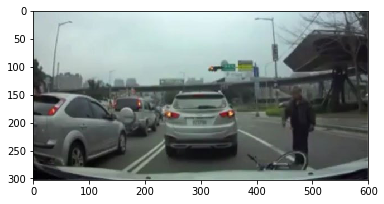

In [19]:
plt.imshow(image)

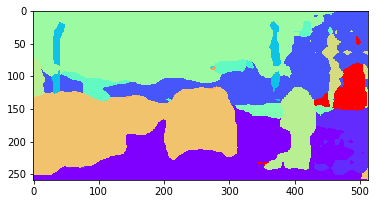

In [20]:
def softmax_to_color(softmax):
    argmax = np.argmax(softmax)
    color = colors[argmax]
    #color_hsv = matplotlib.colors.rgb_to_hsv(color[:-1])
    #color_hsv[1] = color_hsv[1] * softmax[argmax]
    #color_rgb = matplotlib.colors.hsv_to_rgb(color_hsv)
    return color[:-1]

rgb_softmax = np.zeros(softmax.shape[:-1] + (3,))
for i in range(softmax.shape[0]):
    for j in range(softmax.shape[1]):
        rgb_softmax[i][j] = softmax_to_color(softmax[i][j])

plt.imshow(rgb_softmax)

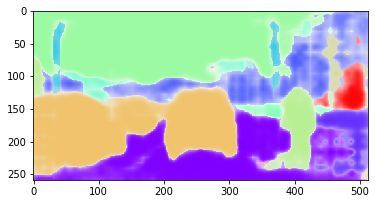

In [21]:
# changing saturation in hsv
def softmax_to_color_intensity(softmax):
    argmax = np.argmax(softmax)
    color = colors[argmax]
    color_hsv = matplotlib.colors.rgb_to_hsv(color[:-1])
    color_hsv[1] = color_hsv[1] * softmax[argmax]
    color_rgb = matplotlib.colors.hsv_to_rgb(color_hsv)
    return color_rgb

rgb_intensity = np.zeros(softmax.shape[:-1] + (3,))
for i in range(softmax.shape[0]):
    for j in range(softmax.shape[1]):
        rgb_intensity[i][j] = softmax_to_color_intensity(softmax[i][j])

plt.imshow(rgb_intensity)

In [28]:
# multiplying rgb channels

def softmax_to_color_intensity2(softmax):
    argmax = np.argmax(softmax)
    color = colors[argmax] * softmax[argmax]
    return color[:-1]

rgb_intensity = np.zeros(softmax.shape[:-1] + (3,))
for i in range(softmax.shape[0]):
    for j in range(softmax.shape[1]):
        rgb_intensity[i][j] = softmax_to_color_intensity2(softmax[i][j])

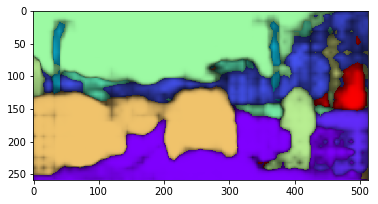

In [30]:
plt.imshow(rgb_intensity)